In [163]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

In [164]:
root = os.getcwd()
parent = os.path.join(root, 'data', 'rain')
filename = os.listdir(parent)[0]
file_path = os.path.join(parent, filename)

In [165]:
## read file into a dataframe
df_orig = pd.read_csv(file_path)

In [166]:
## Create a copy of the original dataframe
df = df_orig.copy()

### Plan of action to pre-process the data

1. Target variable for this data set is the RainTomorrow variable
2. There are complications here since the data is time series data, there could e strong autocorrelations in the data
3. Also given that there are locations in the data set there could also be strong spatial correlations that we need to watch out for
4. Want to test the data for auto-correlation using: Durbin Watson test or Ljung-Box tets
    a. The Adj. Dickey-Fuller test (ADF) is used to check for stationarity in timeseries data
    b. ACF & PACF plot are also a visual way to check for Auto-correlation
5. Train test split. Given the data is imbalanced interms of the labels, sugegst to do a startified sampling bsed on label set
6. Need to draw out the pre-processing pipeline:
    a. Missing values ffill and bfill. 
        1. Try median imputation as well 
        2. Try 3-day moving average as imputation technique
        3. Check the overall statistics using describe and check difference between all three
    b. Add the derived variable: Temp range
    c. Scale (Standardize/Normalize) the numerical variable
    d. Check if any of the variables can be discretized
7. Have a bunch of candidate models for the task
8. Use cross validation for model selection and hyper-parameter tuning (Grid/Randomized search CV)
9. Evaluate Generalization error
10.Monitor the performance of the model
11. Check if updated data is available on the Australian website to download

In [167]:
## Getting a high level feel of the data set
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [169]:
## Start by conveting the Date column to datetime
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [170]:
## Check for irregularities in time series
gaps = df.groupby(['Location', 'Date'])['Date'].mean().diff().rename('gaps').reset_index()
gaps[gaps.gaps > pd.Timedelta(value=1, unit='days')]

## Start by creating an index of contiguous date ranges
dts = pd.date_range(start=df.Date.min(), end=df.Date.max(), freq='D')
locs = df.Location.unique()
cross_join = pd.DataFrame(itertools.product(dts, locs), columns=['Date', 'Location'])

# # Alternative way to create a cross-join
# dts = pd.date_range(start=df.Date.min(), end=df.Date.max(), freq='D').to_frame(name='Date')
# dts['key'] = 0
# locs = pd.DataFrame(df.Location.unique(), columns=['Location'])
# locs['key'] = 0
# cross_join = dts.merge(locs, on='key', how='outer').drop('key', axis=1)

df = df.merge(cross_join, on=['Date', 'Location'], how='outer')

In [171]:
# Incomplete data.
## A. Dropping data prior to a particular timeperiod due to data being incomplete
df = df[df.Date.dt.year>=2009]

In [172]:
# Handling missing values
## Check for the current % of missing values in the dataset
def get_missing(df):
    s = df.isna().sum(axis=0)*100/len(df)
    s = s[s>0].to_frame(name='miss_pct')
    s = s.join(df.dtypes.to_frame(name='data_type'), how='left')
    # s = s.merge(df.dtypes.to_frame(),how='left', left_index=True, right_index=True)
    return s

#### Calculating % of missing values in each column
get_missing(df)

,miss_pct,data_type
MinTemp,6.684365,float64
MaxTemp,6.538781,float64
Rainfall,7.845088,float64
Evaporation,46.853138,float64
Sunshine,51.504592,float64
WindGustDir,12.217230,object
WindGustSpeed,12.176388,float64
WindDir9am,12.613141,object
WindDir3pm,8.483419,object
WindSpeed9am,6.857617,float64


In [173]:
# Handling missing values

## A. Dropping columns with high % of missing values
miss_cols = get_missing(df)
#### dropping coumns where there are more than 20% of values missing
miss_cols = miss_cols[miss_cols.miss_pct>20].index.values ## .values returs an nd-numpy array
miss_cols
df = df.drop(miss_cols, axis=1)

In [174]:
## B. Dropping Locations with missing values (i.e. data not being captured)

miss_loc = df.groupby('Location').count()
miss_loc = (miss_loc == 0).any(axis=1)
miss_loc = miss_loc[miss_loc==True].index.values

#### Check count of data pointsfor these locations in the dataset
df['Location'].value_counts()/len(df)  # Most locations are pretty uniformly distributed interm of count

#### Based on the above looks like dropping these locations is not going to significantly impact the analysis
#### Dropping the locations missing ceratain variables
df = df[~df.Location.isin(miss_loc)]    # given that this is not an index based drop, instead of using the drop function we simply filter the dataset

In [175]:
# Imputation of Missing values

## Opportunity to impute Temp3PM with MaxTemp and vice-versa
df['Temp3pm'] = df['Temp3pm'].combine_first(df['MaxTemp']) 
df['MaxTemp'] = df['MaxTemp'].combine_first(df['Temp3pm']) 

## Rainfall. If Raintoday = No, then rainfall is zero 
df['Rainfall'] = np.where(df.RainToday == 'No', 0.0, df.Rainfall)
# df[df.Rainfall.notna()&df.RainToday.isna()][['Rainfall', 'RainToday']]

In [176]:
# DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False
#                , right_index=False, sort=False, suffixes=('_x', '_y'), copy=None, indicator=False, validate=None)

In [177]:
## Imputation if missing values for categorical variables

cat_miss = get_missing(df)
cat_miss = cat_miss[cat_miss.data_type=='object'].index.values.tolist()
cat_miss = list(set(cat_miss)-set(['RainTomorrow', 'RainToday']))

# ## Forward filling missing categorical variables

df[cat_miss] = df[['Location', 'Date']+cat_miss].sort_values(by=['Location', 'Date'])\
        .groupby('Location').fillna(method='ffill', axis=0).fillna(method='bfill', axis=0)[cat_miss]

In [178]:
df = df.sort_values(by=['Location', 'Date'])

In [179]:
get_missing(df)
# stats_orig = df.describe().T

,miss_pct,data_type
MinTemp,6.696402,float64
MaxTemp,6.546746,float64
Rainfall,8.137948,float64
WindGustSpeed,8.492282,float64
WindSpeed9am,6.837256,float64
WindSpeed3pm,6.810846,float64
Humidity9am,7.340513,float64
Humidity3pm,7.810758,float64
Pressure9am,8.170227,float64
Pressure3pm,8.143817,float64


In [180]:
## Imputation if missing values for numeric variables
## Three possible options
## Method 1: Imputation with ffill/bfill
## Method 2: Imputation with simple mean/median
## Method 3: Imputation with rolling mean/median (simple/exponential)

num_miss = get_missing(df)
num_miss = num_miss[num_miss.data_type!='object'].index.values.tolist()
num_miss = list(set(num_miss)-set(['Rainfall']))   # rainfall will be handled separately. Set needs a list passed set('Rainfall') didn't work 
num_miss

#### Method 1: Imputation with ffill/bfill
# df[num_miss] = df[['Location', 'Date']+num_miss].sort_values(by=['Location', 'Date'])\
#         .groupby('Location').fillna(method='ffill', axis=0).fillna(method='bfill', axis=0)[num_miss]
# stats_1 = df.describe().T

#### Method 2a: Imputation with simple mean
# df[num_miss] = df[num_miss].combine_first(df.groupby('Location')[num_miss].transform('mean'))
# stats_2a = df.describe().T

#### Method 2b: Imputation with simple median
# df[num_miss] = df[num_miss].combine_first(df.groupby('Location')[num_miss].transform('median'))
# stats_2b = df.describe().T

#### Method 3a: Imputation with simple 3day rolling average
rolling_df = df.sort_values(by=['Location', 'Date']).groupby('Location')\
                .rolling('3D', closed='left', axis=0, on='Date')[num_miss].mean(skipna=True).reset_index()\
                .set_index(df.index).ffill()[num_miss]
df[num_miss] = df[num_miss].combine_first(rolling_df)
# stats_3a = df.describe().T

#### Method 3b: Imputation with simple 3day rolling average
# exp_df = df.sort_values(by=['Location', 'Date']).groupby('Location')\
#                 .ewm(span=3, closed='left', axis=0, on='Date')[num_miss].mean(skipna=True).reset_index()\
#                 .set_index(df.index).ffill()[num_miss]
# df[num_miss] = df[num_miss].combine_first(exp_df)
# stats_3b = df.describe().T

In [201]:
## First step is check the target variable

### We may have an opportunity to fill missing values in target based on the values in RainToday column
pd.crosstab(df.RainToday.isna(), df.RainTomorrow.isna())

RainTomorrow,False
RainToday,
False,125332


In [199]:
# Cleaning up target variable

### So start by dropping rows with both values missing
df = df[~((df.RainTomorrow.isna())&(df.RainToday.isna()))]

## Check if we can impute the Rain tomorrow columns with Rain Today from next day

df['rainTom_prev_day'] = df.sort_values(by=['Location', 'Date']).groupby('Location')['RainTomorrow'].shift(1)
df['rainTod_next_day'] = df.sort_values(by=['Location', 'Date']).groupby('Location')['RainToday'].shift(-1)

# # quick check
# df[(df.Date.dt.year>=2009) & (df.Date <= df.Date.min()+pd.Timedelta(value=1, unit='days'))]   # works since NaNs are populated at the first day of each locaion


df['RainTomorrow'] = df['RainTomorrow'].combine_first(df['rainTod_next_day'])
df['RainToday'] = df['RainToday'].combine_first(df['rainTom_prev_day'])

# # Doesn't look like there is much opportunity here
# df[df.RainTomorrow.isna()|df.RainToday.isna()]

## Dropping rows where values for target variable are missing
df = df[df.RainTomorrow.notna()].drop(['rainTod_next_day', 'rainTom_prev_day'], axis=1)

## Finally drop rows which do not have values for Rainfall
df = df[df.RainToday.notna()]
df['Rainfall'] = np.where(df.RainToday == 'No', 0.0, df.Rainfall)
df['Rainfall'] = df['Rainfall'].combine_first(df.groupby('Location')['Rainfall'].transform('mean'))

## Dropping the derived columns
# df = df.drop(['rainTod_next_day', 'rainTom_prev_day'], axis=1)

In [202]:
## Imputing the rainfall column
df[df.Rainfall.isna()]

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow


In [203]:
# Adding additional columns to the dataset
df['temp_day_range'] = df['MaxTemp']-df['MinTemp']

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125332 entries, 96504 to 108569
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            125332 non-null  datetime64[ns]
 1   Location        125332 non-null  object        
 2   MinTemp         125332 non-null  float64       
 3   MaxTemp         125332 non-null  float64       
 4   Rainfall        125332 non-null  float64       
 5   WindGustDir     125332 non-null  object        
 6   WindGustSpeed   125332 non-null  float64       
 7   WindDir9am      125332 non-null  object        
 8   WindDir3pm      125332 non-null  object        
 9   WindSpeed9am    125332 non-null  float64       
 10  WindSpeed3pm    125332 non-null  float64       
 11  Humidity9am     125332 non-null  float64       
 12  Humidity3pm     125332 non-null  float64       
 13  Pressure9am     125332 non-null  float64       
 14  Pressure3pm     125332 non-null 

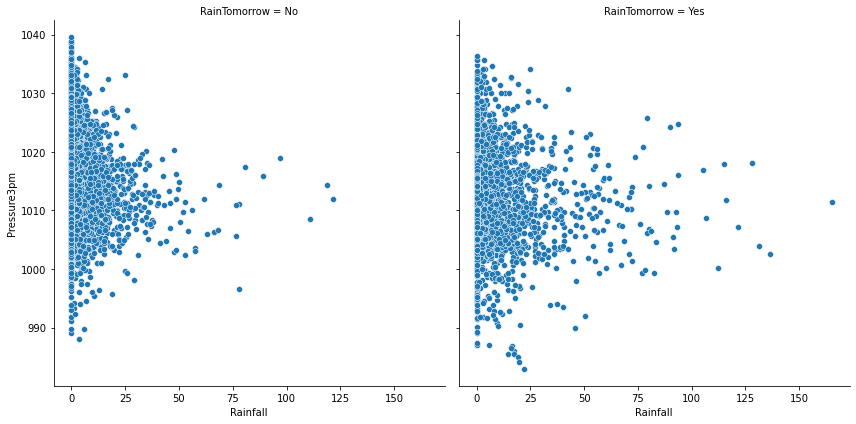

In [210]:
g = sns.relplot(data=df[df.Date.dt.year==2010]
            , x='Rainfall', y='Pressure3pm'
            , col='RainTomorrow'#, hue='Location'
            , kind='scatter'
            , height=6, aspect=1
           )

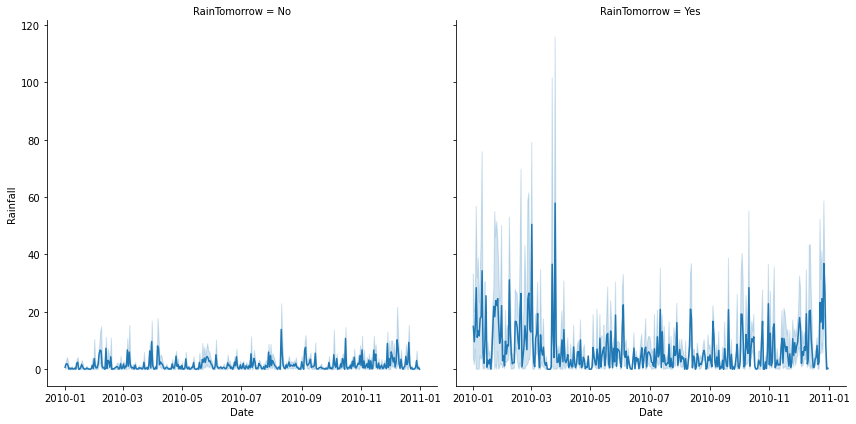

In [205]:
g = sns.relplot(data=df[df.Date.dt.year==2010]
            , x='Date', y='Rainfall'
            , col='RainTomorrow'#, hue='Location'
            , kind='line'
            , height=6, aspect=1
           )

In [ ]:
# sns.pairplot(data=df.sample(1000)
#              , diag_kind='kde'
#              , hue='RainToday'
#             )

In [ ]:
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

### Plan of action to pre-process the data

1. Target variable for this data set is the RainTomorrow variable
2. There are complications here since the data is time series data, there could e strong autocorrelations in the data
3. Also given that there are locations in the data set there could also be strong spatial correlations that we need to watch out for
4. Want to test the data for auto-correlation using: Durbin Watson test or Ljung-Box tets
    a. The Adj. Dickey-Fuller test (ADF) is used to check for stationarity in timeseries data
    b. ACF & PACF plot are also a visual way to check for Auto-correlation
5. Train test split. Given the data is imbalanced interms of the labels, suggest to do a startified sampling based on label set
6. Need to draw out the pre-processing pipeline:
    a. Missing values ffill and bfill. 
        1. Try median imputation as well 
        2. Try 3-day moving average as imputation technique
        3. Check the overall statistics using describe and check difference between all three
    b. Add the derived variable: Temp range
    c. Scale (Standardize/Normalize) the numerical variable
    d. Check if any of the variables can be discretized
7. Have a bunch of candidate models for the task
8. Use cross validation for model selection and hyper-parameter tuning (Grid/Randomized search CV)
9. Evaluate Generalization error
10.Monitor the performance of the model
11. Check if updated data is available on the Australian website to download


In [ ]:
import sklearn as sk